In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime, timedelta

In [2]:
def fetch_historical_data(ticker: str):

        end_date = datetime.today()
        start_date = end_date - timedelta(days=1825)
        end_str = end_date.strftime("%Y-%m-%d")
        start_str = start_date.strftime("%Y-%m-%d")

        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_str, end=end_str)
        hist.reset_index(inplace=True)

        return hist

        # # Convert dataframe to list of dicts for JSON serialization
        # data = hist.to_dict(orient="records")

        # filename = f"{ticker}_{period}_historical.json"
        # with open(filename, "w") as f:
        #     json.dump(data, f, indent=4, default=str)

In [3]:
df = fetch_historical_data("AAPL")

In [4]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-05-26 00:00:00-04:00,78.616088,78.795918,76.914967,76.970863,125522000,0.0,0.0
1,2020-05-27 00:00:00-04:00,76.827469,77.452018,76.086262,77.306206,112945200,0.0,0.0
2,2020-05-28 00:00:00-04:00,76.980580,78.601508,76.703544,77.340248,133560800,0.0,0.0
3,2020-05-29 00:00:00-04:00,77.583260,78.044991,76.907672,77.264908,153532400,0.0,0.0
4,2020-06-01 00:00:00-04:00,77.218738,78.336619,77.087507,78.215111,80791200,0.0,0.0
...,...,...,...,...,...,...,...,...
1250,2025-05-15 00:00:00-04:00,210.949997,212.960007,209.539993,211.449997,45029500,0.0,0.0
1251,2025-05-16 00:00:00-04:00,212.360001,212.570007,209.770004,211.259995,54737900,0.0,0.0
1252,2025-05-19 00:00:00-04:00,207.910004,209.479996,204.259995,208.779999,46140500,0.0,0.0
1253,2025-05-20 00:00:00-04:00,207.669998,208.470001,205.029999,206.860001,42496600,0.0,0.0


Preparing data...
Loading and processing asset data...
Processing AAPL...
Processing GOOGL...
Processing MSFT...
Processing TSLA...
Processing SPY...
Training model...
Epoch 0: Train Loss: 0.3769, Val Loss: 0.3755


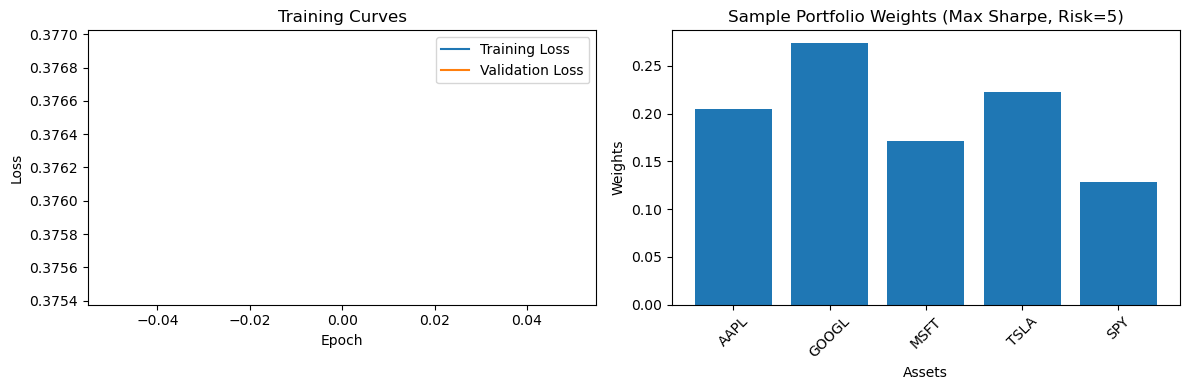

Pipeline completed successfully!
Sample prediction - Asset weights: {'AAPL': 0.204351, 'GOOGL': 0.27352506, 'MSFT': 0.17104423, 'TSLA': 0.22286853, 'SPY': 0.12821111}

Example Predictions:
Max Sharpe (Risk=3): {'AAPL': 0.205, 'GOOGL': 0.246, 'MSFT': 0.183, 'TSLA': 0.216, 'SPY': 0.151}
Max Sharpe (Risk=5): {'AAPL': 0.204, 'GOOGL': 0.274, 'MSFT': 0.171, 'TSLA': 0.223, 'SPY': 0.128}
Max Sharpe (Risk=8): {'AAPL': 0.2, 'GOOGL': 0.331, 'MSFT': 0.148, 'TSLA': 0.23, 'SPY': 0.091}
Min Volatility (Risk=3): {'AAPL': 0.198, 'GOOGL': 0.201, 'MSFT': 0.201, 'TSLA': 0.198, 'SPY': 0.201}
Min Volatility (Risk=5): {'AAPL': 0.199, 'GOOGL': 0.201, 'MSFT': 0.201, 'TSLA': 0.199, 'SPY': 0.201}
Min Volatility (Risk=8): {'AAPL': 0.199, 'GOOGL': 0.201, 'MSFT': 0.201, 'TSLA': 0.199, 'SPY': 0.201}
Equal Risk Contribution (Risk=3): {'AAPL': 0.199, 'GOOGL': 0.201, 'MSFT': 0.201, 'TSLA': 0.199, 'SPY': 0.201}
Equal Risk Contribution (Risk=5): {'AAPL': 0.199, 'GOOGL': 0.201, 'MSFT': 0.2, 'TSLA': 0.199, 'SPY': 0.201}
Eq

In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# ================== DATA PREPROCESSING MODULE ==================

class FeatureExtractor:
    """Extract features from price data for portfolio optimization"""
    
    def __init__(self, lookback_periods: List[int] = [20, 60, 252]):
        self.lookback_periods = lookback_periods
        self.scaler = StandardScaler()
        
    def calculate_returns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculate various return metrics"""
        features = pd.DataFrame(index=df.index)
        
        # Simple returns
        features['returns_1d'] = df['Close'].pct_change()
        features['returns_5d'] = df['Close'].pct_change(5)
        features['returns_20d'] = df['Close'].pct_change(20)
        
        # Log returns
        features['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
        
        return features
    
    def calculate_volatility(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculate volatility measures"""
        features = pd.DataFrame(index=df.index)
        returns = df['Close'].pct_change()
        
        for period in self.lookback_periods:
            features[f'vol_{period}d'] = returns.rolling(period).std() * np.sqrt(252)
            features[f'realized_vol_{period}d'] = returns.rolling(period).std()
            
        return features
    
    def calculate_technical_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculate technical indicators"""
        features = pd.DataFrame(index=df.index)
        
        # Moving averages
        for period in [20, 50, 200]:
            features[f'sma_{period}'] = df['Close'].rolling(period).mean()
            features[f'price_sma_ratio_{period}'] = df['Close'] / features[f'sma_{period}']
            
        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        features['rsi'] = 100 - (100 / (1 + rs))
        
        # Bollinger Bands
        sma_20 = df['Close'].rolling(20).mean()
        std_20 = df['Close'].rolling(20).std()
        features['bb_upper'] = sma_20 + (2 * std_20)
        features['bb_lower'] = sma_20 - (2 * std_20)
        features['bb_position'] = (df['Close'] - features['bb_lower']) / (features['bb_upper'] - features['bb_lower'])
        
        return features
    
    def calculate_risk_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculate risk-related metrics"""
        features = pd.DataFrame(index=df.index)
        returns = df['Close'].pct_change()
        
        # Maximum Drawdown
        peak = df['Close'].cummax()
        drawdown = (df['Close'] - peak) / peak
        features['current_drawdown'] = drawdown
        features['max_drawdown_20d'] = drawdown.rolling(20).min()
        features['max_drawdown_60d'] = drawdown.rolling(60).min()
        
        # VaR approximation (assuming normal distribution)
        for period in [20, 60]:
            vol = returns.rolling(period).std()
            mean_ret = returns.rolling(period).mean()
            features[f'var_95_{period}d'] = mean_ret - 1.645 * vol
            features[f'var_99_{period}d'] = mean_ret - 2.33 * vol
            
        # Upside/Downside volatility
        upside_returns = returns.where(returns > 0, 0)
        downside_returns = returns.where(returns < 0, 0)
        
        features['upside_vol_20d'] = upside_returns.rolling(20).std() * np.sqrt(252)
        features['downside_vol_20d'] = downside_returns.rolling(20).std() * np.sqrt(252)
        
        return features
    
    def calculate_momentum_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculate momentum indicators"""
        features = pd.DataFrame(index=df.index)
        
        # Price momentum
        for period in [20, 60, 252]:
            features[f'momentum_{period}d'] = df['Close'] / df['Close'].shift(period) - 1
            
        # Volume-weighted indicators
        if 'Volume' in df.columns:
            # Volume-weighted average price
            features['vwap_20d'] = (df['Close'] * df['Volume']).rolling(20).sum() / df['Volume'].rolling(20).sum()
            features['price_vwap_ratio'] = df['Close'] / features['vwap_20d']
            
            # Volume momentum
            features['volume_sma_20'] = df['Volume'].rolling(20).mean()
            features['volume_ratio'] = df['Volume'] / features['volume_sma_20']
        
        return features
    
    def extract_all_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract all features from a single asset's data"""
        feature_dfs = []
        
        # Calculate all feature types
        feature_dfs.append(self.calculate_returns(df))
        feature_dfs.append(self.calculate_volatility(df))
        feature_dfs.append(self.calculate_technical_indicators(df))
        feature_dfs.append(self.calculate_risk_metrics(df))
        feature_dfs.append(self.calculate_momentum_indicators(df))
        
        # Combine all features
        features = pd.concat(feature_dfs, axis=1)
        
        # Forward fill and backward fill to handle NaN values
        features = features.fillna(method='ffill').fillna(method='bfill')
        
        # Drop any remaining NaN rows
        features = features.dropna()
        
        return features


class PortfolioDataProcessor:
    """Process portfolio data for ML model training"""
    
    def __init__(self, assets: List[str], fetch_function, sequence_length: int = 60):
        self.assets = assets
        self.fetch_function = fetch_function
        self.sequence_length = sequence_length
        self.feature_extractor = FeatureExtractor()
        self.scalers = {}
        self.feature_names = None
        
    def load_and_process_data(self) -> Tuple[np.ndarray, List[str]]:
        """Load and process data for all assets"""
        asset_features = {}
        
        print("Loading and processing asset data...")
        for asset in self.assets:
            print(f"Processing {asset}...")
            
            # Fetch raw data
            df = self.fetch_function(asset)
            
            # Extract features
            features = self.feature_extractor.extract_all_features(df)
            
            # Store processed features
            asset_features[asset] = features
            
        # Align all assets to the same date range
        common_dates = None
        for asset, features in asset_features.items():
            if common_dates is None:
                common_dates = features.index
            else:
                common_dates = common_dates.intersection(features.index)
        
        # Create aligned feature matrix
        aligned_features = {}
        for asset in self.assets:
            aligned_features[asset] = asset_features[asset].loc[common_dates]
            
        # Stack features for all assets
        feature_matrix = []
        self.feature_names = list(aligned_features[self.assets[0]].columns)
        
        for i, date in enumerate(common_dates):
            if i < self.sequence_length:
                continue
                
            # Get sequence of features for all assets
            asset_sequences = []
            for asset in self.assets:
                asset_seq = aligned_features[asset].iloc[i-self.sequence_length:i].values
                asset_sequences.append(asset_seq)
                
            # Stack all assets horizontally [sequence_length, features, n_assets]
            combined_seq = np.stack(asset_sequences, axis=-1)
            feature_matrix.append(combined_seq)
            
        feature_matrix = np.array(feature_matrix)
        date_index = common_dates[self.sequence_length:]
        
        return feature_matrix, date_index
    
    def normalize_features(self, features: np.ndarray, fit: bool = True) -> np.ndarray:
        """Normalize features using StandardScaler"""
        # Reshape for scaling: [samples * sequence_length * n_assets, features]
        original_shape = features.shape
        reshaped = features.reshape(-1, features.shape[2])
        
        if fit:
            self.scalers['features'] = StandardScaler()
            normalized = self.scalers['features'].fit_transform(reshaped)
        else:
            normalized = self.scalers['features'].transform(reshaped)
            
        # Reshape back to original
        return normalized.reshape(original_shape)


# ================== DATASET MODULE ==================

class PortfolioDataset(Dataset):
    """PyTorch Dataset for portfolio optimization"""
    
    def __init__(self, features: np.ndarray, strategies: List[str], risk_tolerances: List[int]):
        self.features = torch.FloatTensor(features)
        self.n_samples = len(features)
        self.n_assets = features.shape[3]
        
        # Strategy encoding
        strategy_mapping = {
            'max_sharpe': [1, 0, 0],
            'min_volatility': [0, 1, 0],
            'equal_risk_contribution': [0, 0, 1]
        }
        
        # Create all combinations of features, strategies, and risk tolerances
        self.samples = []
        for i in range(self.n_samples):
            for strategy in strategies:
                for risk_tolerance in risk_tolerances:
                    self.samples.append({
                        'features': self.features[i],
                        'strategy': torch.FloatTensor(strategy_mapping[strategy]),
                        'risk_tolerance': torch.FloatTensor([risk_tolerance / 10.0])  # Normalize to [0,1]
                    })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]


# ================== MODEL MODULE ==================

class PortfolioOptimizer(nn.Module):
    """Neural network for portfolio weight optimization"""
    
    def __init__(self, n_features: int, n_assets: int, sequence_length: int):
        super(PortfolioOptimizer, self).__init__()
        self.n_features = n_features
        self.n_assets = n_assets
        self.sequence_length = sequence_length
        
        # Asset-wise LSTM encoder
        self.asset_lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        
        # Asset feature encoder
        self.asset_encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Cross-asset attention
        self.attention = nn.MultiheadAttention(
            embed_dim=32,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )
        
        # Strategy and risk encoding
        self.strategy_encoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU()
        )
        
        self.risk_encoder = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU()
        )
        
        # Portfolio decoder
        portfolio_input_size = 32 * n_assets + 16 + 8  # Asset features + strategy + risk
        self.portfolio_decoder = nn.Sequential(
            nn.Linear(portfolio_input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, n_assets),
            nn.Softmax(dim=-1)  # Ensure weights sum to 1
        )
        
    def forward(self, features, strategy, risk_tolerance):
        batch_size = features.shape[0]
        
        # Process each asset through LSTM
        asset_encodings = []
        for i in range(self.n_assets):
            asset_features = features[:, :, :, i]  # [batch, sequence, features]
            lstm_out, _ = self.asset_lstm(asset_features)
            # Take last hidden state
            asset_encoding = lstm_out[:, -1, :]  # [batch, hidden_size]
            asset_encoding = self.asset_encoder(asset_encoding)
            asset_encodings.append(asset_encoding)
        
        # Stack asset encodings
        asset_encodings = torch.stack(asset_encodings, dim=1)  # [batch, n_assets, encoding_dim]
        
        # Apply cross-asset attention
        attended_features, _ = self.attention(
            asset_encodings, asset_encodings, asset_encodings
        )
        
        # Flatten asset features
        flattened_assets = attended_features.reshape(batch_size, -1)
        
        # Encode strategy and risk
        strategy_encoding = self.strategy_encoder(strategy)
        risk_encoding = self.risk_encoder(risk_tolerance)
        
        # Combine all features
        combined_features = torch.cat([
            flattened_assets,
            strategy_encoding,
            risk_encoding
        ], dim=-1)
        
        # Generate portfolio weights
        weights = self.portfolio_decoder(combined_features)
        
        return weights


# ================== LOSS FUNCTION MODULE ==================

class PortfolioLoss(nn.Module):
    """Portfolio optimization loss function"""
    
    def __init__(self):
        super(PortfolioLoss, self).__init__()
        
    def calculate_portfolio_metrics(self, weights, returns, covariance_matrix):
        """Calculate portfolio return, volatility, and risk contributions"""
        # Portfolio return (assuming equal weighting for historical returns)
        portfolio_returns = torch.sum(weights.unsqueeze(1) * returns, dim=-1)
        mean_return = torch.mean(portfolio_returns, dim=1)
        
        # Portfolio volatility
        portfolio_variance = torch.sum(
            weights.unsqueeze(1) * (covariance_matrix * weights.unsqueeze(2)), 
            dim=[-1, -2]
        )
        portfolio_vol = torch.sqrt(portfolio_variance + 1e-8)
        
        # Risk contributions for equal risk contribution strategy
        marginal_risk = torch.sum(covariance_matrix * weights.unsqueeze(2), dim=-1)
        risk_contributions = weights * marginal_risk / (portfolio_vol.unsqueeze(1) + 1e-8)
        
        return mean_return, portfolio_vol, risk_contributions
    
    def forward(self, weights, strategy, risk_tolerance, returns, covariance_matrix):
        # Calculate portfolio metrics
        portfolio_return, portfolio_vol, risk_contributions = self.calculate_portfolio_metrics(
            weights, returns, covariance_matrix
        )
        
        # Initialize loss
        loss = torch.zeros_like(portfolio_return)
        
        # Max Sharpe strategy
        max_sharpe_mask = strategy[:, 0] > 0.5
        if max_sharpe_mask.sum() > 0:
            sharpe_ratio = portfolio_return[max_sharpe_mask] / (portfolio_vol[max_sharpe_mask] + 1e-8)
            loss[max_sharpe_mask] = -sharpe_ratio  # Negative because we want to maximize
        
        # Min Volatility strategy
        min_vol_mask = strategy[:, 1] > 0.5
        if min_vol_mask.sum() > 0:
            loss[min_vol_mask] = portfolio_vol[min_vol_mask]
        
        # Equal Risk Contribution strategy
        erc_mask = strategy[:, 2] > 0.5
        if erc_mask.sum() > 0:
            n_assets = weights.shape[1]
            target_contribution = 1.0 / n_assets
            contribution_diff = risk_contributions[erc_mask] - target_contribution
            loss[erc_mask] = torch.sum(contribution_diff ** 2, dim=1)
        
        # Risk tolerance adjustment
        risk_penalty = (1 - risk_tolerance.squeeze()) * portfolio_vol
        loss += risk_penalty
        
        return torch.mean(loss)


# ================== TRAINING MODULE ==================

class PortfolioTrainer:
    """Trainer for portfolio optimization model"""
    
    def __init__(self, model: PortfolioOptimizer, device: str = 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.criterion = PortfolioLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=10
        )
        
    def prepare_batch_data(self, batch, historical_returns, covariance_matrices):
        """Prepare batch data for training"""
        batch_size = len(batch['features'])
        
        # Get historical returns and covariance for this batch
        # This is a simplified version - in practice, you'd want to calculate
        # returns and covariance from the actual feature data
        returns = historical_returns[:batch_size]
        cov_matrix = covariance_matrices[:batch_size]
        
        return (
            batch['features'].to(self.device),
            batch['strategy'].to(self.device),
            batch['risk_tolerance'].to(self.device),
            returns.to(self.device),
            cov_matrix.to(self.device)
        )
    
    def train_epoch(self, dataloader, historical_returns, covariance_matrices):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        
        for batch in dataloader:
            features, strategy, risk_tolerance, returns, cov_matrix = self.prepare_batch_data(
                batch, historical_returns, covariance_matrices
            )
            
            # Forward pass
            weights = self.model(features, strategy, risk_tolerance)
            
            # Calculate loss
            loss = self.criterion(weights, strategy, risk_tolerance, returns, cov_matrix)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
        
        return total_loss / len(dataloader)
    
    def validate_epoch(self, dataloader, historical_returns, covariance_matrices):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch in dataloader:
                features, strategy, risk_tolerance, returns, cov_matrix = self.prepare_batch_data(
                    batch, historical_returns, covariance_matrices
                )
                
                weights = self.model(features, strategy, risk_tolerance)
                loss = self.criterion(weights, strategy, risk_tolerance, returns, cov_matrix)
                total_loss += loss.item()
        
        return total_loss / len(dataloader)
    
    def train(self, train_loader, val_loader, historical_returns, covariance_matrices, epochs: int = 100):
        """Full training loop"""
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            # Training
            train_loss = self.train_epoch(train_loader, historical_returns, covariance_matrices)
            
            # Validation
            val_loss = self.validate_epoch(val_loader, historical_returns, covariance_matrices)
            
            # Learning rate scheduling
            self.scheduler.step(val_loss)
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_portfolio_model.pth')
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Load best model
        self.model.load_state_dict(torch.load('best_portfolio_model.pth'))
        
        return train_losses, val_losses


# ================== MAIN EXECUTION MODULE ==================

class PortfolioOptimizationPipeline:
    """Complete pipeline for portfolio optimization"""
    
    def __init__(self, assets: List[str], fetch_function):
        self.assets = assets
        self.fetch_function = fetch_function
        self.processor = None
        self.model = None
        self.trainer = None
        
    def prepare_data(self, sequence_length: int = 60):
        """Prepare data for training"""
        print("Preparing data...")
        self.processor = PortfolioDataProcessor(self.assets, self.fetch_function, sequence_length)
        
        # Load and process data
        features, dates = self.processor.load_and_process_data()
        
        # Normalize features
        features = self.processor.normalize_features(features, fit=True)
        
        # Calculate historical returns and covariance matrices
        # This is simplified - in practice, you'd calculate these from the actual price data
        n_samples, seq_len, n_features, n_assets = features.shape
        historical_returns = torch.randn(n_samples, seq_len, n_assets)  # Placeholder
        covariance_matrices = torch.eye(n_assets).unsqueeze(0).repeat(n_samples, 1, 1)  # Placeholder
        
        return features, historical_returns, covariance_matrices, dates
    
    def create_datasets(self, features, strategies=None, risk_tolerances=None, test_size=0.2):
        """Create train/validation datasets"""
        if strategies is None:
            strategies = ['max_sharpe', 'min_volatility', 'equal_risk_contribution']
        if risk_tolerances is None:
            risk_tolerances = list(range(1, 11))
        
        # Split data
        train_features, val_features = train_test_split(
            features, test_size=test_size, random_state=42, shuffle=False
        )
        
        # Create datasets
        train_dataset = PortfolioDataset(train_features, strategies, risk_tolerances)
        val_dataset = PortfolioDataset(val_features, strategies, risk_tolerances)
        
        return train_dataset, val_dataset
    
    def train_model(self, train_dataset, val_dataset, historical_returns, covariance_matrices, 
                   batch_size=32, epochs=100):
        """Train the portfolio optimization model"""
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        n_features = train_dataset.samples[0]['features'].shape[1]
        sequence_length = train_dataset.samples[0]['features'].shape[0]
        n_assets = len(self.assets)
        
        self.model = PortfolioOptimizer(n_features, n_assets, sequence_length)
        
        # Initialize trainer
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.trainer = PortfolioTrainer(self.model, device)
        
        # Train model
        print("Training model...")
        train_losses, val_losses = self.trainer.train(
            train_loader, val_loader, historical_returns, covariance_matrices, epochs
        )
        
        return train_losses, val_losses
    
    def predict_weights(self, features, strategy: str, risk_tolerance: int):
        """Predict optimal portfolio weights"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        
        self.model.eval()
        
        # Prepare strategy encoding
        strategy_mapping = {
            'max_sharpe': [1, 0, 0],
            'min_volatility': [0, 1, 0],
            'equal_risk_contribution': [0, 0, 1]
        }
        
        strategy_tensor = torch.FloatTensor(strategy_mapping[strategy]).unsqueeze(0)
        risk_tensor = torch.FloatTensor([risk_tolerance / 10.0]).unsqueeze(0)
        features_tensor = torch.FloatTensor(features).unsqueeze(0)
        
        with torch.no_grad():
            weights = self.model(features_tensor, strategy_tensor, risk_tensor)
            
        return weights.squeeze().numpy()
    
    def run_complete_pipeline(self):
        """Run the complete pipeline"""
        try:
            # 1. Prepare data
            features, historical_returns, covariance_matrices, dates = self.prepare_data()
            
            # 2. Create datasets
            train_dataset, val_dataset = self.create_datasets(features)
            
            # 3. Train model
            train_losses, val_losses = self.train_model(
                train_dataset, val_dataset, historical_returns, covariance_matrices, epochs = 1
            )
            
            # 4. Plot training curves
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Training Curves')
            
            plt.subplot(1, 2, 2)
            # Example prediction
            sample_features = features[-1]  # Last time step
            weights = self.predict_weights(sample_features, 'max_sharpe', 5)
            
            plt.bar(self.assets, weights)
            plt.xlabel('Assets')
            plt.ylabel('Weights')
            plt.title('Sample Portfolio Weights (Max Sharpe, Risk=5)')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
            print("Pipeline completed successfully!")
            print(f"Sample prediction - Asset weights: {dict(zip(self.assets, weights))}")
            
            return self.model, train_losses, val_losses
            
        except Exception as e:
            print(f"Error in pipeline: {str(e)}")
            raise


# ================== EXAMPLE USAGE ==================

if __name__ == "__main__":
    # Example usage - replace with your actual fetch function
    # def dummy_fetch(ticker):
    #     """Dummy fetch function for demonstration"""
    #     dates = pd.date_range('2019-01-01', '2024-05-16', freq='D')
    #     np.random.seed(hash(ticker) % 2**32)  # Consistent random data per ticker
        
    #     n_days = len(dates)
    #     price = 100 * np.exp(np.cumsum(np.random.normal(0.0001, 0.02, n_days)))
        
    #     df = pd.DataFrame({
    #         'Date': dates,
    #         'Open': price * np.random.uniform(0.98, 1.02, n_days),
    #         'High': price * np.random.uniform(1.00, 1.05, n_days),
    #         'Low': price * np.random.uniform(0.95, 1.00, n_days),
    #         'Close': price,
    #         'Volume': np.random.randint(1000000, 50000000, n_days),
    #         'Dividends': np.zeros(n_days),
    #         'Stock Splits': np.zeros(n_days)
    #     })
    #     df.set_index('Date', inplace=True)
    #     return df
    
    # Define portfolio assets
    assets = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'SPY']
    
    # Run pipeline
    pipeline = PortfolioOptimizationPipeline(assets, fetch_and_store_historical)
    model, train_losses, val_losses = pipeline.run_complete_pipeline()
    
    # Example predictions for different strategies
    sample_features = pipeline.processor.normalize_features(
        features=np.random.randn(1, 60, len(pipeline.processor.feature_names), len(assets)),
        fit=False
    )[0]
    
    print("\nExample Predictions:")
    for strategy in ['max_sharpe', 'min_volatility', 'equal_risk_contribution']:
        for risk in [3, 5, 8]:
            weights = pipeline.predict_weights(sample_features, strategy, risk)
            print(f"{strategy.replace('_', ' ').title()} (Risk={risk}): {dict(zip(assets, np.round(weights, 3)))}")

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Union

# Define the top 10 stocks to use as our universal set
TOP_STOCKS = [
    'AAPL',  # Apple
    'MSFT',  # Microsoft
    'AMZN',  # Amazon
    'GOOGL', # Alphabet
    'META',  # Meta Platforms
    'TSLA',  # Tesla
    'BRK-B', # Berkshire Hathaway
    'JPM',   # JPMorgan Chase
    'JNJ',   # Johnson & Johnson
    'V'      # Visa
]

class DataProcessor:
    """Module for processing historical price data"""
    
    @staticmethod
    def calculate_returns(prices_df: pd.DataFrame, period: int = 1) -> pd.DataFrame:
        """Calculate returns from price data using closing prices"""
        return prices_df['Close'].pct_change(period).dropna()
    
    @staticmethod
    def calculate_features(prices_df: pd.DataFrame, window: int = 20) -> pd.DataFrame:
        """Extract features from price data"""
        # Using closing prices for calculations
        close_prices = prices_df['Close'].values
        
        features = pd.DataFrame()
        # Returns over different periods
        features['returns_1d'] = np.append(np.nan, np.diff(close_prices) / close_prices[:-1])
        
        # Volatility features
        features['volatility_20d'] = features['returns_1d'].rolling(window=window).std()
        
        # Momentum features
        features['momentum_20d'] = close_prices / close_prices[-window] - 1 if len(close_prices) >= window else np.nan
        
        # Volume features if available
        if 'Volume' in prices_df.columns:
            features['volume_ratio'] = prices_df['Volume'] / prices_df['Volume'].rolling(window=window).mean()
        
        # Additional technical indicators could be added here
        
        return features.dropna()
    
    @staticmethod
    def align_data_for_multiple_assets(assets_data: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
        """Ensure all assets data have the same date range"""
        # Find common date range
        common_dates = None
        
        for ticker, df in assets_data.items():
            if common_dates is None:
                common_dates = set(df.index)
            else:
                common_dates = common_dates.intersection(set(df.index))
        
        common_dates = sorted(list(common_dates))
        
        # Filter all dataframes to common date range
        aligned_data = {}
        for ticker, df in assets_data.items():
            aligned_data[ticker] = df.loc[common_dates]
            
        return aligned_data
    
    @staticmethod
    def normalize_features(features_dict: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
        """Normalize features for all assets"""
        scaler = StandardScaler()
        normalized_features = {}
        
        # Combine all features to fit the scaler
        all_features = pd.concat([df for df in features_dict.values()], axis=0)
        scaler.fit(all_features.values)
        
        # Apply the scaler to each asset's features
        for ticker, features in features_dict.items():
            normalized_features[ticker] = pd.DataFrame(
                scaler.transform(features.values),
                index=features.index,
                columns=features.columns
            )
            
        return normalized_features


class PortfolioDataset(Dataset):
    """Dataset for portfolio optimization model training and evaluation"""
    
    def __init__(self, 
                 returns_dict: Dict[str, pd.DataFrame],
                 features_dict: Dict[str, pd.DataFrame],
                 window_size: int = 252,
                 num_samples: int = 1000,
                 tickers: List[str] = TOP_STOCKS,
                 training: bool = True):
        """
        Initialize dataset
        
        Args:
            returns_dict: Dictionary of returns dataframes for each ticker
            features_dict: Dictionary of features dataframes for each ticker
            window_size: Number of days to use for historical window
            num_samples: Number of samples to generate for training
            tickers: List of tickers to include in the universe
            training: Whether this is for training (random sampling) or testing
        """
        self.returns_dict = returns_dict
        self.features_dict = features_dict
        self.window_size = window_size
        self.num_samples = num_samples
        self.tickers = tickers
        self.num_assets = len(tickers)
        self.training = training
        
        # Ensure all tickers have data
        valid_tickers = []
        for ticker in self.tickers:
            if ticker in self.returns_dict and ticker in self.features_dict:
                valid_tickers.append(ticker)
        
        self.tickers = valid_tickers
        self.num_assets = len(valid_tickers)
        
        # Find common dates across all tickers for both returns and features
        common_dates = None
        for ticker in self.tickers:
            returns_dates = set(self.returns_dict[ticker].index)
            features_dates = set(self.features_dict[ticker].index)
            ticker_dates = returns_dates.intersection(features_dates)
            
            if common_dates is None:
                common_dates = ticker_dates
            else:
                common_dates = common_dates.intersection(ticker_dates)
        
        # Convert to list and sort
        self.aligned_dates = sorted(list(common_dates))
        
        # Ensure there's enough data for the window size
        if len(self.aligned_dates) <= window_size:
            raise ValueError(f"Not enough data for window size {window_size}. Only {len(self.aligned_dates)} dates available.")
        
        self.valid_start_indices = list(range(len(self.aligned_dates) - window_size))
        
    def __len__(self):
        if self.training:
            return self.num_samples
        else:
            return len(self.valid_start_indices)
        
    def __getitem__(self, idx):
        if self.training:
            # Random starting point for training
            start_idx = np.random.choice(self.valid_start_indices)
            
            # Random subset of assets (at least 2 assets)
            num_active = np.random.randint(2, self.num_assets + 1)
            active_indices = np.random.choice(self.num_assets, num_active, replace=False)
            
            # Random optimization strategy (0: Max Sharpe, 1: Min Vol, 2: ERC)
            strategy = np.random.randint(0, 3)
            
            # Random risk tolerance
            risk_tolerance = np.random.randint(1, 11)
            
        else:
            # Sequential for testing
            start_idx = self.valid_start_indices[idx]
            
            # Use all assets for testing
            active_indices = np.arange(self.num_assets)
            
            # Fixed parameters for consistent testing
            strategy = 0  # Max Sharpe
            risk_tolerance = 5  # Moderate risk
        
        # Get the corresponding dates for this window
        end_idx = start_idx + self.window_size
        window_dates = self.aligned_dates[start_idx:end_idx]
        
        # Create mask for active assets
        mask = np.zeros(self.num_assets)
        mask[active_indices] = 1
        
        # Prepare strategy one-hot encoding
        strategy_onehot = np.zeros(3)
        strategy_onehot[strategy] = 1
        
        # Collect returns and features for all assets in the window
        returns_window = np.zeros((self.window_size, self.num_assets))
        features_window = np.zeros((self.window_size, self.num_assets, 4))  # Assuming 4 features per asset
        
        for i, ticker in enumerate(self.tickers):
            # Extract returns for this window
            ticker_returns = self.returns_dict[ticker].loc[window_dates].values
            returns_window[:, i] = ticker_returns
            
            # Extract features for this window
            ticker_features = self.features_dict[ticker].loc[window_dates].values
            # Handle case where features might have different dimensions
            if ticker_features.ndim == 1:
                features_window[:, i, 0] = ticker_features
            else:
                # Handle case where the feature matrix may have fewer than 4 features
                n_features = min(ticker_features.shape[1], 4)
                features_window[:, i, :n_features] = ticker_features[:, :n_features]
        
        # Calculate target weights based on strategy and active assets
        active_returns = returns_window[:, active_indices]
        target_weights = self._calculate_target_weights(
            active_returns,
            strategy,
            risk_tolerance,
            active_indices
        )
        
        return {
            'returns': torch.tensor(returns_window, dtype=torch.float32),
            'features': torch.tensor(features_window, dtype=torch.float32),
            'mask': torch.tensor(mask, dtype=torch.float32),
            'strategy': torch.tensor(strategy_onehot, dtype=torch.float32),
            'risk_tolerance': torch.tensor([risk_tolerance/10.0], dtype=torch.float32),
            'target_weights': torch.tensor(target_weights, dtype=torch.float32)
        }
    
    def _calculate_target_weights(self, 
                                 returns: np.ndarray,
                                 strategy: int,
                                 risk_tolerance: int,
                                 active_indices: np.ndarray) -> np.ndarray:
        """Calculate target weights based on optimization strategy
        
        Args:
            returns: Returns array for active assets [window_size, num_active]
            strategy: Strategy index (0: Max Sharpe, 1: Min Vol, 2: ERC)
            risk_tolerance: Risk tolerance level (1-10)
            active_indices: Indices of active assets
            
        Returns:
            Array of target weights [num_assets]
        """
        num_active = len(active_indices)
        full_weights = np.zeros(self.num_assets)
        
        # Skip the first few returns which might be NaN
        valid_returns = returns[~np.isnan(returns).any(axis=1)]
        
        # If no valid returns, use equal weights
        if len(valid_returns) < 2:
            active_weights = np.ones(num_active) / num_active
            full_weights[active_indices] = active_weights
            return full_weights
        
        if strategy == 0:  # Maximum Sharpe Ratio
            # Simple estimation of Sharpe-optimal weights
            mean_returns = np.mean(valid_returns, axis=0)
            cov_matrix = np.cov(valid_returns.T) if valid_returns.shape[0] > 1 else np.eye(valid_returns.shape[1])
            
            # Handle potential numerical issues
            if np.any(np.diag(cov_matrix) <= 0):
                active_weights = np.ones(num_active) / num_active
            else:
                # Simplified approach, not true max Sharpe optimization
                vol = np.sqrt(np.diag(cov_matrix))
                sharpe = mean_returns / vol
                
                # Adjust based on risk tolerance
                sharpe_adj = sharpe * (risk_tolerance / 5.0)
                
                if np.sum(sharpe_adj > 0) > 0:
                    active_weights = np.maximum(sharpe_adj, 0)
                    if np.sum(active_weights) > 0:
                        active_weights = active_weights / np.sum(active_weights)
                    else:
                        active_weights = np.ones(num_active) / num_active
                else:
                    active_weights = np.ones(num_active) / num_active
                    
        elif strategy == 1:  # Minimum Volatility
            # Simple estimation of min-vol weights
            if valid_returns.shape[0] > 1:
                cov_matrix = np.cov(valid_returns.T)
            else:
                # If not enough data, use identity matrix
                cov_matrix = np.eye(valid_returns.shape[1])
            
            # Use inverse volatility weighting as an approximation
            vol = np.sqrt(np.diag(cov_matrix))
            if np.any(vol <= 0):
                active_weights = np.ones(num_active) / num_active
            else:
                inv_vol = 1.0 / vol
                active_weights = inv_vol / np.sum(inv_vol)
                
            # Adjust towards equal weights for higher risk tolerance
            equal_weights = np.ones(num_active) / num_active
            risk_factor = risk_tolerance / 10.0
            active_weights = (1 - risk_factor) * active_weights + risk_factor * equal_weights
                
        else:  # Equal Risk Contribution
            if valid_returns.shape[0] > 1:
                cov_matrix = np.cov(valid_returns.T)
            else:
                # If not enough data, use identity matrix
                cov_matrix = np.eye(valid_returns.shape[1])
                
            active_weights = self._equal_risk_contribution(cov_matrix)
            
            # For higher risk tolerance, allow more concentration
            if risk_tolerance > 5:
                mean_returns = np.mean(valid_returns, axis=0)
                
                # Find the assets with above-average returns
                above_avg = mean_returns > np.mean(mean_returns)
                
                # Skew weights towards better performers based on risk tolerance
                skew_factor = (risk_tolerance - 5) / 5.0
                skew = 1.0 + skew_factor * above_avg
                
                active_weights = active_weights * skew
                if np.sum(active_weights) > 0:
                    active_weights = active_weights / np.sum(active_weights)
                else:
                    active_weights = np.ones(num_active) / num_active
        
        # Assign weights to active assets in the full portfolio
        full_weights[active_indices] = active_weights
        return full_weights
    
    def _equal_risk_contribution(self, cov_matrix: np.ndarray) -> np.ndarray:
        """Calculate weights for equal risk contribution
        
        Args:
            cov_matrix: Covariance matrix [num_active, num_active]
            
        Returns:
            Array of weights [num_active]
        """
        n = cov_matrix.shape[0]
        weights = np.ones(n) / n
        
        # Handle case where covariance matrix is all zeros
        if np.all(cov_matrix == 0):
            return weights
        
        # Simple optimization approach for ERC
        for _ in range(100):
            # Calculate portfolio volatility
            portfolio_vol = np.sqrt(weights.T @ cov_matrix @ weights)
            
            # Avoid division by zero
            if portfolio_vol <= 1e-10:
                return np.ones(n) / n
            
            # Calculate marginal risk contribution
            marginal_contrib = (cov_matrix @ weights) / portfolio_vol
            
            # Calculate risk contribution
            risk_contrib = weights * marginal_contrib
            
            # Target equal risk contribution
            target_risk = np.sum(risk_contrib) / n
            
            # Update weights - move towards equal risk contribution
            # Avoid division by zero
            adjustment = np.ones(n)
            for i in range(n):
                if risk_contrib[i] > 1e-10:
                    adjustment[i] = target_risk / risk_contrib[i]
            
            weights = weights * adjustment
            weights = weights / np.sum(weights)
        
        return weights


class AttentionBlock(nn.Module):
    """Self-attention block for modeling asset interactions"""
    
    def __init__(self, hidden_dim: int, num_heads: int = 4):
        super(AttentionBlock, self).__init__()
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        
    def forward(self, x):
        # Self-attention with residual connection
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        
        # Feed-forward with residual connection
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)
        
        return x


class AssetEncoder(nn.Module):
    """Encodes historical asset data into embeddings"""
    
    def __init__(self, 
                 input_dim: int, 
                 hidden_dim: int, 
                 window_size: int,
                 num_layers: int = 1):
        super(AssetEncoder, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=5, padding=2),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # Calculate output size after pooling
        self.pooled_size = window_size // 4
        
        self.lstm = nn.LSTM(
            hidden_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            bidirectional=True
        )
        
        self.output_proj = nn.Linear(hidden_dim * 2, hidden_dim)
        
    def forward(self, x):
        # x shape: [batch_size, window_size, input_dim]
        batch_size, window_size, input_dim = x.size()
        
        # Prepare for Conv1d [batch_size, input_dim, window_size]
        x = x.transpose(1, 2)
        
        # Extract features
        x = self.feature_extractor(x)  # [batch_size, hidden_dim, pooled_size]
        
        # Prepare for LSTM [batch_size, pooled_size, hidden_dim]
        x = x.transpose(1, 2)
        
        # Process with LSTM
        lstm_out, _ = self.lstm(x)  # [batch_size, pooled_size, hidden_dim*2]
        
        # Use the final output of the LSTM
        x = lstm_out[:, -1, :]  # [batch_size, hidden_dim*2]
        
        # Project to final embedding dimension
        x = self.output_proj(x)  # [batch_size, hidden_dim]
        
        return x


class PortfolioOptimizationModel(nn.Module):
    """End-to-end portfolio optimization model"""
    
    def __init__(self, 
                 num_assets: int = 10, 
                 window_size: int = 252, 
                 hidden_dim: int = 64,
                 feature_dim: int = 4,
                 num_strategies: int = 3):
        super(PortfolioOptimizationModel, self).__init__()
        
        self.num_assets = num_assets
        
        # Asset-specific encoders
        self.return_encoder = AssetEncoder(1, hidden_dim, window_size)
        self.feature_encoder = AssetEncoder(feature_dim, hidden_dim, window_size)
        
        # Asset embedding combination
        self.asset_combiner = nn.Linear(hidden_dim * 2, hidden_dim)
        
        # Cross-asset attention
        self.cross_asset_attention = AttentionBlock(hidden_dim)
        
        # Strategy-specific processing
        self.strategy_embedding = nn.Embedding(num_strategies, hidden_dim)
        
        # Risk tolerance processing
        self.risk_embedding = nn.Sequential(
            nn.Linear(1, hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, hidden_dim)
        )
        
        # Combined processing
        self.combined_layer = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU()
        )
        
        # Weight generator
        self.weight_generator = nn.Linear(hidden_dim, num_assets)
        
    def forward(self, 
                returns: torch.Tensor,
                features: torch.Tensor,
                mask: torch.Tensor, 
                strategy: torch.Tensor, 
                risk_tolerance: torch.Tensor):
        batch_size = returns.size(0)
        
        # Process each asset individually
        asset_embeddings = []
        for i in range(self.num_assets):
            # Extract data for this asset
            asset_returns = returns[:, :, i:i+1]  # [batch_size, window_size, 1]
            asset_features = features[:, :, i, :]  # [batch_size, window_size, feature_dim]
            
            # Encode asset data
            return_embedding = self.return_encoder(asset_returns)  # [batch_size, hidden_dim]
            feature_embedding = self.feature_encoder(asset_features)  # [batch_size, hidden_dim]
            
            # Combine embeddings
            asset_embedding = torch.cat([return_embedding, feature_embedding], dim=1)  # [batch_size, hidden_dim*2]
            asset_embedding = self.asset_combiner(asset_embedding)  # [batch_size, hidden_dim]
            
            asset_embeddings.append(asset_embedding)
        
        # Stack asset embeddings [batch_size, num_assets, hidden_dim]
        asset_embeddings = torch.stack(asset_embeddings, dim=1)
        
        # Apply cross-asset attention
        asset_embeddings = self.cross_asset_attention(asset_embeddings)
        
        # Process strategy - convert one-hot to index
        strategy_idx = torch.argmax(strategy, dim=1)
        strategy_embedding = self.strategy_embedding(strategy_idx)  # [batch_size, hidden_dim]
        
        # Process risk tolerance
        risk_embedding = self.risk_embedding(risk_tolerance)  # [batch_size, hidden_dim]
        
        # Combine strategy and risk embeddings
        context_embedding = torch.cat([
            strategy_embedding,
            risk_embedding
        ], dim=1)  # [batch_size, hidden_dim*2]
        
        # Pool asset embeddings with attention to mask
        # Apply mask to asset embeddings
        masked_embeddings = asset_embeddings * mask.unsqueeze(-1)
        
        # Sum pooling of masked embeddings
        pooled_embedding = masked_embeddings.sum(dim=1) / (mask.sum(dim=1, keepdim=True) + 1e-10)  # [batch_size, hidden_dim]
        
        # Combine pooled asset embedding with context
        combined = torch.cat([
            pooled_embedding,
            context_embedding
        ], dim=1)  # [batch_size, hidden_dim*3]
        
        # Process combined features
        hidden = self.combined_layer(combined)  # [batch_size, hidden_dim]
        
        # Generate unnormalized weights
        raw_weights = self.weight_generator(hidden)  # [batch_size, num_assets]
        
        # Apply mask and softmax to get normalized weights for active assets only
        masked_weights = raw_weights * mask - 1e10 * (1 - mask)
        normalized_weights = torch.softmax(masked_weights, dim=1)
        
        return normalized_weights


class PortfolioOptimizer:
    """Main class for portfolio optimization"""
    
    def __init__(self, 
                 model: nn.Module,
                 learning_rate: float = 1e-4,
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Initialize the optimizer
        
        Args:
            model: The portfolio optimization model
            learning_rate: Learning rate for training
            device: Device to use for training ('cuda' or 'cpu')
        """
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
    def train(self, 
              train_loader: DataLoader, 
              val_loader: Optional[DataLoader] = None,
              num_epochs: int = 50,
              early_stopping_patience: int = 10):
        """
        Train the model
        
        Args:
            train_loader: DataLoader for training data
            val_loader: DataLoader for validation data
            num_epochs: Number of epochs to train for
            early_stopping_patience: Number of epochs to wait for validation loss improvement
        """
        best_val_loss = float('inf')
        patience_counter = 0
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            # Training
            self.model.train()
            train_loss = 0.0
            
            for batch in train_loader:
                # Move batch to device
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                # Forward pass
                predicted_weights = self.model(
                    batch['returns'],
                    batch['features'],
                    batch['mask'],
                    batch['strategy'],
                    batch['risk_tolerance']
                )
                
                # Calculate loss
                loss = self._calculate_loss(
                    predicted_weights,
                    batch['target_weights'],
                    batch['mask'],
                    batch['strategy']
                )
                
                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
            
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            
            # Validation
            if val_loader is not None:
                val_loss = self.evaluate(val_loader)
                val_losses.append(val_loss)
                
                print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
                
                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    # Save best model
                    torch.save(self.model.state_dict(), 'best_portfolio_model.pth')
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
            else:
                print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}")
        
        # Load best model if validation was used
        if val_loader is not None:
            self.model.load_state_dict(torch.load('best_portfolio_model.pth'))
            
        return train_losses, val_losses
    
    def evaluate(self, data_loader: DataLoader) -> float:
        """
        Evaluate the model
        
        Args:
            data_loader: DataLoader for evaluation data
            
        Returns:
            Average loss on the evaluation data
        """
        self.model.eval()
        total_loss = 0.0
        
        with torch.no_grad():
            for batch in data_loader:
                # Move batch to device
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                # Forward pass
                predicted_weights = self.model(
                    batch['returns'],
                    batch['features'],
                    batch['mask'],
                    batch['strategy'],
                    batch['risk_tolerance']
                )
                
                # Calculate loss
                loss = self._calculate_loss(
                    predicted_weights,
                    batch['target_weights'],
                    batch['mask'],
                    batch['strategy']
                )
                
                total_loss += loss.item()
        
        return total_loss / len(data_loader)
    
    def predict(self, 
                returns: np.ndarray,
                features: np.ndarray,
                active_tickers: List[str],
                strategy_idx: int = 0,
                risk_tolerance: int = 5) -> Dict[str, float]:
        """
        Generate portfolio weights for given input
        
        Args:
            returns: Historical returns array [window_size, num_assets]
            features: Features array [window_size, num_assets, feature_dim]
            active_tickers: List of tickers to include in the portfolio
            strategy_idx: Strategy index (0: Max Sharpe, 1: Min Vol, 2: ERC)
            risk_tolerance: Risk tolerance level (1-10)
            
        Returns:
            Dictionary mapping tickers to weights
        """
        self.model.eval()
        
        # Create mask based on active tickers
        all_tickers = TOP_STOCKS
        mask = np.zeros(len(all_tickers))
        for ticker in active_tickers:
            if ticker in all_tickers:
                idx = all_tickers.index(ticker)
                mask[idx] = 1
        
        # Prepare strategy one-hot encoding
        strategy_onehot = np.zeros(3)
        strategy_onehot[strategy_idx] = 1
        
        # Convert inputs to tensors and add batch dimension
        returns_tensor = torch.tensor(returns, dtype=torch.float32).unsqueeze(0).to(self.device)
        features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(self.device)
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).to(self.device)
        strategy_tensor = torch.tensor(strategy_onehot, dtype=torch.float32).unsqueeze(0).to(self.device)
        risk_tensor = torch.tensor([risk_tolerance/10.0], dtype=torch.float32).unsqueeze(0).to(self.device)
        
        # Generate weights
        with torch.no_grad():
            predicted_weights = self.model(
                returns_tensor,
                features_tensor,
                mask_tensor,
                strategy_tensor,
                risk_tensor
            )
        
        # Convert to numpy and remove batch dimension
        weights = predicted_weights.cpu().numpy()[0]
        
        # Create dictionary mapping tickers to weights
        portfolio = {}
        for i, ticker in enumerate(all_tickers):
            if mask[i] > 0 and weights[i] > 0.001:  # Only include assets with non-trivial weights
                portfolio[ticker] = weights[i]
        
        return portfolio
    
    def _calculate_loss(self, 
                        predicted_weights: torch.Tensor,
                        target_weights: torch.Tensor,
                        mask: torch.Tensor,
                        strategy: torch.Tensor) -> torch.Tensor:
        """
        Calculate the loss based on the optimization strategy
        
        Args:
            predicted_weights: Predicted portfolio weights
            target_weights: Target portfolio weights
            mask: Mask indicating active assets
            strategy: One-hot encoded strategy
            
        Returns:
            Loss value
        """
        # Mean squared error between predicted and target weights
        mse_loss = torch.mean(((predicted_weights - target_weights) ** 2) * mask)
        
        # Add regularization for weight concentration
        sum_squared = torch.sum(predicted_weights ** 2, dim=1)
        concentration_penalty = torch.mean(sum_squared)
        
        # Total loss
        loss = mse_loss + 0.01 * concentration_penalty
        
        return loss


def prepare_data_pipeline(fetch_historical_data_fn, tickers=TOP_STOCKS, window_size=252):
    """
    Prepare data pipeline for model training and evaluation
    
    Args:
        fetch_historical_data_fn: Function to fetch historical data for a ticker
        tickers: List of tickers to include
        window_size: Number of days to use for historical window
        
    Returns:
        train_loader, val_loader, test_loader
    """
    # Fetch data for all tickers
    raw_data = {}
    for ticker in tickers:
        try:
            raw_data[ticker] = fetch_historical_data_fn(ticker)
            print(f"Fetched data for {ticker}")
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    
    # Process data
    processor = DataProcessor()
    
    # Calculate returns and features
    returns_dict = {}
    features_dict = {}
    
    for ticker, df in raw_data.items():
        # Calculate returns
        returns = processor.calculate_returns(df)
        returns_dict[ticker] = returns
        
        # Calculate features
        features = processor.calculate_features(df)
        features_dict[ticker] = features
    
    # Align data across all assets
    returns_dict = processor.align_data_for_multiple_assets(returns_dict)
    features_dict = processor.align_data_for_multiple_assets(features_dict)
    
    # Normalize features
    features_dict = processor.normalize_features(features_dict)
    
    # Create datasets
    train_dataset = PortfolioDataset(
        returns_dict=returns_dict,
        features_dict=features_dict,
        window_size=window_size,
        num_samples=5000,
        tickers=tickers,
        training=True
    )
    
    val_dataset = PortfolioDataset(
        returns_dict=returns_dict,
        features_dict=features_dict,
        window_size=window_size,
        num_samples=1000,
        tickers=tickers,
        training=True
    )
    
    test_dataset = PortfolioDataset(
        returns_dict=returns_dict,
        features_dict=features_dict,
        window_size=window_size,
        num_samples=1000,
        tickers=tickers,
        training=False
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    return train_loader, val_loader, test_loader, (returns_dict, features_dict)


def train_model(train_loader, val_loader, num_assets=10, window_size=252):
    """
    Train the portfolio optimization model
    
    Args:
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_assets: Number of assets in the universe
        window_size: Number of days in the historical window
        
    Returns:
        Trained model
    """
    # Initialize model
    model = PortfolioOptimizationModel(
        num_assets=num_assets,
        window_size=window_size,
        hidden_dim=64,
        feature_dim=4
    )
    
    # Initialize optimizer
    optimizer = PortfolioOptimizer(model, learning_rate=1e-4)
    
    # Train model
    train_losses, val_losses = optimizer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=1,
        early_stopping_patience=10
    )
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_curve.png')
    plt.close()
    
    return model, optimizer


def evaluate_model(model_optimizer, test_loader):
    """
    Evaluate the model on test data
    
    Args:
        model_optimizer: Trained model optimizer
        test_loader: DataLoader for test data
        
    Returns:
        Test loss
    """
    test_loss = model_optimizer.evaluate(test_loader)
    print(f"Test Loss: {test_loss:.6f}")
    return test_loss


def backtest_portfolio(model_optimizer, data_tuple, tickers=TOP_STOCKS, window_size=252, 
                       test_period=60, strategy_idx=0, risk_tolerance=5):
    """
    Backtest the portfolio optimization model
    
    Args:
        model_optimizer: Trained model optimizer
        data_tuple: Tuple of (returns_dict, features_dict)
        tickers: List of tickers to include
        window_size: Number of days in the historical window
        test_period: Number of days to test
        strategy_idx: Strategy index (0: Max Sharpe, 1: Min Vol, 2: ERC)
        risk_tolerance: Risk tolerance level (1-10)
        
    Returns:
        Backtest results
    """
    returns_dict, features_dict = data_tuple
    
    # Get common dates
    common_dates = sorted(list(returns_dict[tickers[0]].index))
    
    # Select test period
    test_dates = common_dates[-test_period:]
    
    # Initialize results
    portfolio_values = [1.0]
    portfolio_weights_history = []
    
    # Run backtest
    for i in range(len(test_dates) - 1):
        current_date = test_dates[i]
        next_date = test_dates[i+1]
        
        # Get historical window ending on current date
        window_end_idx = common_dates.index(current_date)
        window_start_idx = window_end_idx - window_size + 1
        window_dates = common_dates[window_start_idx:window_end_idx+1]
        
        # Prepare input data
        returns_window = np.zeros((window_size, len(tickers)))
        features_window = np.zeros((window_size, len(tickers), 4))
        
        for j, ticker in enumerate(tickers):
            returns_window[:, j] = returns_dict[ticker].loc[window_dates].values
            features_window[:, j, :] = features_dict[ticker].loc[window_dates].values
        
        # Generate portfolio weights
        portfolio_weights = model_optimizer.predict(
            returns=returns_window,
            features=features_window,
            active_tickers=tickers,
            strategy_idx=strategy_idx,
            risk_tolerance=risk_tolerance
        )
        
        portfolio_weights_history.append(portfolio_weights)
        
        # Calculate portfolio return
        portfolio_return = 0.0
        for ticker, weight in portfolio_weights.items():
            ticker_idx = tickers.index(ticker)
            ticker_return = returns_dict[ticker].loc[next_date]
            portfolio_return += weight * ticker_return
        
        # Update portfolio value
        portfolio_values.append(portfolio_values[-1] * (1 + portfolio_return))
    
    # Calculate performance metrics
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    annual_return = np.mean(portfolio_returns) * 252
    annual_volatility = np.std(portfolio_returns) * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility > 0 else 0
    max_drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values) / np.max(portfolio_values)
    
    # Plot portfolio performance
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(test_dates, portfolio_values)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Backtest Performance')
    plt.grid(True)
    
    # Plot portfolio composition
    plt.subplot(2, 1, 2)
    weights_data = []
    for weights in portfolio_weights_history:
        weight_vector = []
        for ticker in tickers:
            weight_vector.append(weights.get(ticker, 0))
        weights_data.append(weight_vector)
    
    weights_array = np.array(weights_data)
    plt.stackplot(test_dates[:-1], weights_array.T, labels=tickers, alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Weight')
    plt.title('Portfolio Composition')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig('backtest_results.png')
    plt.close()
    
    # Return results
    results = {
        'portfolio_values': portfolio_values,
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'portfolio_weights_history': portfolio_weights_history
    }
    
    return results


def compare_strategies(model_optimizer, data_tuple, tickers=TOP_STOCKS, window_size=252, test_period=60):
    """
    Compare different portfolio optimization strategies
    
    Args:
        model_optimizer: Trained model optimizer
        data_tuple: Tuple of (returns_dict, features_dict)
        tickers: List of tickers to include
        window_size: Number of days in the historical window
        test_period: Number of days to test
        
    Returns:
        Comparison results
    """
    strategies = [
        {'name': 'Maximum Sharpe Ratio', 'idx': 0, 'risk': 5},
        {'name': 'Minimum Volatility', 'idx': 1, 'risk': 5},
        {'name': 'Equal Risk Contribution', 'idx': 2, 'risk': 5},
        {'name': 'High Risk (Max Sharpe)', 'idx': 0, 'risk': 8},
        {'name': 'Low Risk (Min Vol)', 'idx': 1, 'risk': 2}
    ]
    
    # Run backtest for each strategy
    results = {}
    for strategy in strategies:
        print(f"Backtesting {strategy['name']}...")
        strategy_results = backtest_portfolio(
            model_optimizer=model_optimizer,
            data_tuple=data_tuple,
            tickers=tickers,
            window_size=window_size,
            test_period=test_period,
            strategy_idx=strategy['idx'],
            risk_tolerance=strategy['risk']
        )
        results[strategy['name']] = strategy_results
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    for strategy_name, strategy_results in results.items():
        plt.plot(strategy_results['portfolio_values'], label=strategy_name)
    
    plt.xlabel('Trading Day')
    plt.ylabel('Portfolio Value')
    plt.title('Strategy Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('strategy_comparison.png')
    plt.close()
    
    # Compile performance metrics
    performance_summary = pd.DataFrame(columns=['Annual Return', 'Annual Volatility', 'Sharpe Ratio', 'Max Drawdown'])
    
    for strategy_name, strategy_results in results.items():
        performance_summary.loc[strategy_name] = [
            f"{strategy_results['annual_return']*100:.2f}%",
            f"{strategy_results['annual_volatility']*100:.2f}%",
            f"{strategy_results['sharpe_ratio']:.2f}",
            f"{strategy_results['max_drawdown']*100:.2f}%"
        ]
    
    return performance_summary, results


def optimize_portfolio_for_subset(model_optimizer, data_tuple, subset_tickers, 
                                  strategy_name="Maximum Sharpe Ratio", risk_tolerance=5):
    """
    Optimize a portfolio for a subset of assets
    
    Args:
        model_optimizer: Trained model optimizer
        data_tuple: Tuple of (returns_dict, features_dict)
        subset_tickers: List of tickers in the subset
        strategy_name: Strategy name
        risk_tolerance: Risk tolerance level (1-10)
        
    Returns:
        Optimized portfolio weights
    """
    returns_dict, features_dict = data_tuple
    all_tickers = TOP_STOCKS
    
    # Map strategy name to index
    strategy_map = {
        "Maximum Sharpe Ratio": 0,
        "Minimum Volatility": 1,
        "Equal Risk Contribution": 2
    }
    strategy_idx = strategy_map.get(strategy_name, 0)
    
    # Get common dates
    common_dates = sorted(list(returns_dict[all_tickers[0]].index))
    window_size = 252
    
    # Use the most recent window
    window_dates = common_dates[-window_size:]
    
    # Prepare input data
    returns_window = np.zeros((window_size, len(all_tickers)))
    features_window = np.zeros((window_size, len(all_tickers), 4))
    
    for j, ticker in enumerate(all_tickers):
        returns_window[:, j] = returns_dict[ticker].loc[window_dates].values
        features_window[:, j, :] = features_dict[ticker].loc[window_dates].values
    
    # Generate portfolio weights
    portfolio_weights = model_optimizer.predict(
        returns=returns_window,
        features=features_window,
        active_tickers=subset_tickers,
        strategy_idx=strategy_idx,
        risk_tolerance=risk_tolerance
    )
    
    # Format results
    result_df = pd.DataFrame(columns=['Weight'])
    for ticker, weight in portfolio_weights.items():
        result_df.loc[ticker] = [f"{weight*100:.2f}%"]
    
    # Calculate expected portfolio metrics
    subset_returns = np.zeros((len(window_dates), len(subset_tickers)))
    for i, ticker in enumerate(subset_tickers):
        ticker_idx = all_tickers.index(ticker)
        subset_returns[:, i] = returns_window[:, ticker_idx]
    
    weights_array = np.array([portfolio_weights.get(ticker, 0) for ticker in subset_tickers])
    
    # Calculate portfolio metrics
    mean_returns = np.mean(subset_returns, axis=0) * 252
    cov_matrix = np.cov(subset_returns.T) * 252
    
    portfolio_return = np.sum(mean_returns * weights_array)
    portfolio_volatility = np.sqrt(weights_array.T @ cov_matrix @ weights_array)
    sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else 0
    
    # Format portfolio metrics
    metrics = {
        "Expected Annual Return": f"{portfolio_return*100:.2f}%",
        "Expected Annual Volatility": f"{portfolio_volatility*100:.2f}%",
        "Expected Sharpe Ratio": f"{sharpe_ratio:.2f}"
    }
    
    return result_df, metrics


def main(fetch_historical_data_fn):
    """
    Main function to run the portfolio optimization pipeline
    
    Args:
        fetch_historical_data_fn: Function to fetch historical data for a ticker
    """
    # Prepare data
    print("Preparing data...")
    train_loader, val_loader, test_loader, data_tuple = prepare_data_pipeline(
        fetch_historical_data_fn=fetch_historical_data_fn,
        tickers=TOP_STOCKS,
        window_size=252
    )
    
    # Train model
    print("Training model...")
    model, optimizer = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        num_assets=len(TOP_STOCKS),
        window_size=252
    )
    
    # Evaluate model
    print("Evaluating model...")
    test_loss = evaluate_model(
        model_optimizer=optimizer,
        test_loader=test_loader
    )
    
    # Backtest model
    print("Running backtest...")
    backtest_results = backtest_portfolio(
        model_optimizer=optimizer,
        data_tuple=data_tuple,
        tickers=TOP_STOCKS,
        window_size=252,
        test_period=60
    )
    
    # Compare strategies
    print("Comparing strategies...")
    performance_summary, strategy_results = compare_strategies(
        model_optimizer=optimizer,
        data_tuple=data_tuple,
        tickers=TOP_STOCKS,
        window_size=252,
        test_period=60
    )
    
    print("\nPerformance Summary:")
    print(performance_summary)
    
    # Example: Optimize a 5-asset portfolio
    subset_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META']
    print(f"\nOptimizing portfolio for subset: {subset_tickers}")
    
    weights_df, metrics = optimize_portfolio_for_subset(
        model_optimizer=optimizer,
        data_tuple=data_tuple,
        subset_tickers=subset_tickers,
        strategy_name="Maximum Sharpe Ratio",
        risk_tolerance=5
    )
    
    print("\nOptimized Weights:")
    print(weights_df)
    
    print("\nExpected Portfolio Metrics:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    
    print("\nAll done!")

def fetch_historical_data(ticker: str):

        end_date = datetime.today()
        start_date = end_date - timedelta(days=1825)
        end_str = end_date.strftime("%Y-%m-%d")
        start_str = start_date.strftime("%Y-%m-%d")

        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_str, end=end_str)
        hist.reset_index(inplace=True)

        return hist


# Example usage
if __name__ == "__main__":
    # You would replace this with your actual function to fetch historical data

    main(fetch_historical_data)

Preparing data...
Fetched data for AAPL
Fetched data for MSFT
Fetched data for AMZN
Fetched data for GOOGL
Fetched data for META
Fetched data for TSLA
Fetched data for BRK-B
Fetched data for JPM
Fetched data for JNJ
Fetched data for V
Training model...
Epoch 1/1 - Train Loss: 0.007841, Val Loss: 0.007432
Evaluating model...


/tmp/ipykernel_54946/2961482869.py:685: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('best_portfolio_model.pth'))


Test Loss: 0.009925
Running backtest...
Comparing strategies...
Backtesting Maximum Sharpe Ratio...
Backtesting Minimum Volatility...
Backtesting Equal Risk Contribution...
Backtesting High Risk (Max Sharpe)...
Backtesting Low Risk (Min Vol)...

Performance Summary:
                        Annual Return Annual Volatility Sharpe Ratio  \
Maximum Sharpe Ratio            6.18%            35.18%         0.18   
Minimum Volatility              5.95%            34.20%         0.17   
Equal Risk Contribution         3.66%            31.60%         0.12   
High Risk (Max Sharpe)          6.27%            35.24%         0.18   
Low Risk (Min Vol)              5.80%            34.11%         0.17   

                        Max Drawdown  
Maximum Sharpe Ratio          16.11%  
Minimum Volatility            15.89%  
Equal Risk Contribution       15.23%  
High Risk (Max Sharpe)        16.12%  
Low Risk (Min Vol)            15.88%  

Optimizing portfolio for subset: ['AAPL', 'MSFT', 'AMZN', 'GOOGL'

In [32]:
from fastapi import FastAPI, HTTPException, UploadFile, File, Form, BackgroundTasks
from fastapi.responses import JSONResponse
from pydantic import BaseModel, Field
from typing import List, Dict, Optional, Union, Any
import numpy as np
import pandas as pd
import torch
import json
import io
import logging
import os
import pickle
from datetime import datetime

# # Import the existing classes (assumed to be in a separate file)
# from portfolio_model import (
#     DataProcessor, PortfolioDataset, PortfolioOptimizationModel, 
#     PortfolioOptimizer, TOP_STOCKS
# )

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Create FastAPI app
app = FastAPI(
    title="Portfolio Optimization API",
    description="API for ML-based portfolio optimization with universal and local modes",
    version="1.0.0"
)

# Define model storage paths
MODEL_DIR = "models"
DATA_DIR = "data"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Global model and data storage
model_storage = {}
data_storage = {}
training_status = {}

# Pydantic models for request/response validation
class AssetData(BaseModel):
    ticker: str
    data: Dict[str, List[float]]  # Date -> [Open, High, Low, Close, Volume]

class TrainingRequest(BaseModel):
    model_id: str
    num_epochs: int = 50
    batch_size: int = 32
    learning_rate: float = 1e-4
    hidden_dim: int = 64

class OptimizationRequest(BaseModel):
    model_id: str
    subset_tickers: Optional[List[str]] = None
    strategy: str = "Maximum Sharpe Ratio"
    risk_tolerance: int = Field(5, ge=1, le=10)

class LocalModeRequest(BaseModel):
    model_id: str
    asset_mask: List[int]  # Binary vector
    strategy: int = Field(0, ge=0, le=2)
    risk_tolerance: int = Field(5, ge=1, le=10)

class ModelInfoResponse(BaseModel):
    model_id: str
    tickers: List[str]
    trained: bool
    last_updated: str
    window_size: int

class PortfolioOptimizationAPI:
    """API for portfolio optimization model"""
    
    def __init__(self, model_id: str, window_size: int = 252):
        """Initialize API with a model ID"""
        self.model_id = model_id
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = None
        self.optimizer = None
        self.data_tuple = None
        self.tickers = TOP_STOCKS.copy()
        self.trained = False
        self.window_size = window_size
        self.last_updated = datetime.now().isoformat()
    
    def universal_mode(self, asset_data: Dict[str, pd.DataFrame]):
        """Set up universal mode with user-provided assets"""
        # Validate input data format
        for ticker, df in asset_data.items():
            if not isinstance(df, pd.DataFrame):
                raise ValueError(f"Data for {ticker} must be a pandas DataFrame")
            if 'Close' not in df.columns:
                raise ValueError(f"DataFrame for {ticker} must contain a 'Close' column")
        
        # Update tickers list
        self.tickers = list(asset_data.keys())
        logger.info(f"Universal mode activated with {len(self.tickers)} assets: {self.tickers}")
        
        # Process data
        processor = DataProcessor()
        
        # Calculate returns and features
        returns_dict = {}
        features_dict = {}
        
        for ticker, df in asset_data.items():
            # Calculate returns
            returns = processor.calculate_returns(df)
            returns_dict[ticker] = returns
            
            # Calculate features
            features = processor.calculate_features(df)
            features_dict[ticker] = features
        
        # Align data across all assets
        returns_dict = processor.align_data_for_multiple_assets(returns_dict)
        features_dict = processor.align_data_for_multiple_assets(features_dict)
        
        # Normalize features
        features_dict = processor.normalize_features(features_dict)
        
        # Store data
        self.data_tuple = (returns_dict, features_dict)
        self.last_updated = datetime.now().isoformat()
        
        # Return status
        return {
            "status": "success", 
            "message": f"Universal mode set up with {len(self.tickers)} assets"
        }
    
    def train_model(self, 
                   num_epochs: int = 50, 
                   batch_size: int = 32, 
                   learning_rate: float = 1e-4, 
                   hidden_dim: int = 64):
        """Train the model with current data"""
        if self.data_tuple is None:
            raise ValueError("No data available. Call universal_mode first.")
        
        returns_dict, features_dict = self.data_tuple
        
        # Create datasets
        train_dataset = PortfolioDataset(
            returns_dict=returns_dict,
            features_dict=features_dict,
            window_size=self.window_size,
            num_samples=5000,
            tickers=self.tickers,
            training=True
        )
        
        val_dataset = PortfolioDataset(
            returns_dict=returns_dict,
            features_dict=features_dict,
            window_size=self.window_size,
            num_samples=1000,
            tickers=self.tickers,
            training=True
        )
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
        
        # Initialize model
        self.model = PortfolioOptimizationModel(
            num_assets=len(self.tickers),
            window_size=self.window_size,
            hidden_dim=hidden_dim,
            feature_dim=4
        )
        
        # Initialize optimizer
        self.optimizer = PortfolioOptimizer(
            model=self.model, 
            learning_rate=learning_rate,
            device=self.device
        )
        
        # Train model
        logger.info(f"Training model with {len(self.tickers)} assets for {num_epochs} epochs...")
        training_status[self.model_id] = "training"
        
        try:
            train_losses, val_losses = self.optimizer.train(
                train_loader=train_loader,
                val_loader=val_loader,
                num_epochs=num_epochs,
                early_stopping_patience=10
            )
            
            self.trained = True
            self.last_updated = datetime.now().isoformat()
            training_status[self.model_id] = "completed"
            
            # Save model and data
            self._save_model()
            self._save_data()
            
            # Return training results
            return {
                "status": "success",
                "message": "Model trained successfully",
                "metrics": {
                    "final_train_loss": float(train_losses[-1]),
                    "final_val_loss": float(val_losses[-1]),
                    "epochs_completed": len(train_losses)
                }
            }
        except Exception as e:
            training_status[self.model_id] = f"failed: {str(e)}"
            logger.error(f"Training failed: {str(e)}")
            raise e
    
    def optimize_portfolio(self, 
                          subset_tickers: List[str] = None, 
                          strategy: str = "Maximum Sharpe Ratio", 
                          risk_tolerance: int = 5):
        """Generate optimal portfolio weights for a subset of assets (Universal Mode)"""
        if not self.trained:
            raise ValueError("Model not trained. Call train_model first.")
        
        if subset_tickers is None:
            subset_tickers = self.tickers
        else:
            # Validate that all tickers exist in our universe
            for ticker in subset_tickers:
                if ticker not in self.tickers:
                    raise ValueError(f"Ticker {ticker} not found in model universe")
        
        # Map strategy name to index
        strategy_map = {
            "Maximum Sharpe Ratio": 0,
            "Minimum Volatility": 1,
            "Equal Risk Contribution": 2
        }
        strategy_idx = strategy_map.get(strategy, 0)
        
        returns_dict, features_dict = self.data_tuple
        
        # Get common dates
        common_dates = sorted(list(returns_dict[self.tickers[0]].index))
        
        # Use the most recent window
        window_dates = common_dates[-self.window_size:]
        
        # Prepare input data
        returns_window = np.zeros((self.window_size, len(self.tickers)))
        features_window = np.zeros((self.window_size, len(self.tickers), 4))
        
        for j, ticker in enumerate(self.tickers):
            returns_window[:, j] = returns_dict[ticker].loc[window_dates].values
            features_window[:, j, :] = features_dict[ticker].loc[window_dates].values
        
        # Generate portfolio weights
        portfolio_weights = self.optimizer.predict(
            returns=returns_window,
            features=features_window,
            active_tickers=subset_tickers,
            strategy_idx=strategy_idx,
            risk_tolerance=risk_tolerance
        )
        
        # Calculate expected portfolio metrics
        active_indices = [self.tickers.index(ticker) for ticker in subset_tickers if ticker in self.tickers]
        subset_returns = returns_window[:, active_indices]
        
        weights_array = np.array([portfolio_weights.get(ticker, 0) for ticker in subset_tickers])
        
        # Calculate portfolio metrics
        mean_returns = np.mean(subset_returns, axis=0) * 252
        cov_matrix = np.cov(subset_returns.T) * 252
        
        portfolio_return = np.sum(mean_returns * weights_array)
        portfolio_volatility = np.sqrt(weights_array.T @ cov_matrix @ weights_array)
        sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else 0
        
        # Format portfolio metrics
        metrics = {
            "Expected Annual Return": f"{portfolio_return*100:.2f}%",
            "Expected Annual Volatility": f"{portfolio_volatility*100:.2f}%",
            "Expected Sharpe Ratio": f"{sharpe_ratio:.2f}"
        }
        
        # Format weights for response
        formatted_weights = {ticker: float(weight) for ticker, weight in portfolio_weights.items()}
        
        return {
            "status": "success",
            "portfolio_weights": formatted_weights,
            "metrics": metrics
        }
    
    def local_mode_predict(self, asset_mask: List[int], strategy_idx: int = 0, risk_tolerance: int = 5):
        """Generate optimal portfolio weights using a binary mask (Local Mode)"""
        if not self.trained:
            raise ValueError("Model not trained. Call train_model first.")
        
        # Validate mask length
        if len(asset_mask) != len(self.tickers):
            raise ValueError(f"Asset mask length ({len(asset_mask)}) must match number of assets ({len(self.tickers)})")
        
        # Convert mask to numpy array
        mask = np.array(asset_mask, dtype=np.float32)
        
        # Get active tickers
        active_tickers = [ticker for i, ticker in enumerate(self.tickers) if mask[i] == 1]
        
        if len(active_tickers) == 0:
            raise ValueError("At least one asset must be active in the mask")
        
        returns_dict, features_dict = self.data_tuple
        
        # Get common dates
        common_dates = sorted(list(returns_dict[self.tickers[0]].index))
        
        # Use the most recent window
        window_dates = common_dates[-self.window_size:]
        
        # Prepare input data
        returns_window = np.zeros((self.window_size, len(self.tickers)))
        features_window = np.zeros((self.window_size, len(self.tickers), 4))
        
        for j, ticker in enumerate(self.tickers):
            returns_window[:, j] = returns_dict[ticker].loc[window_dates].values
            features_window[:, j, :] = features_dict[ticker].loc[window_dates].values
        
        # Generate portfolio weights
        portfolio_weights = self.optimizer.predict(
            returns=returns_window,
            features=features_window,
            active_tickers=active_tickers,
            strategy_idx=strategy_idx,
            risk_tolerance=risk_tolerance
        )
        
        # Create weight vector in the same order as the mask
        weight_vector = np.zeros(len(self.tickers))
        for ticker, weight in portfolio_weights.items():
            idx = self.tickers.index(ticker)
            weight_vector[idx] = weight
        
        return {
            "status": "success",
            "weight_vector": weight_vector.tolist(),
            "portfolio_weights": {ticker: float(weight) for ticker, weight in portfolio_weights.items()}
        }
    
    def _save_model(self):
        """Save model to disk"""
        model_path = os.path.join(MODEL_DIR, f"{self.model_id}_model.pth")
        torch.save(self.model.state_dict(), model_path)
        
    def _save_data(self):
        """Save data to disk"""
        data_path = os.path.join(DATA_DIR, f"{self.model_id}_data.pkl")
        with open(data_path, 'wb') as f:
            pickle.dump({
                'tickers': self.tickers,
                'data_tuple': self.data_tuple,
                'window_size': self.window_size,
                'trained': self.trained,
                'last_updated': self.last_updated
            }, f)
    
    @classmethod
    def load(cls, model_id: str):
        """Load model and data from disk"""
        data_path = os.path.join(DATA_DIR, f"{model_id}_data.pkl")
        model_path = os.path.join(MODEL_DIR, f"{model_id}_model.pth")
        
        if not os.path.exists(data_path) or not os.path.exists(model_path):
            raise FileNotFoundError(f"Model {model_id} not found")
        
        # Load data
        with open(data_path, 'rb') as f:
            data_dict = pickle.load(f)
        
        # Create new instance
        api = cls(model_id, data_dict['window_size'])
        api.tickers = data_dict['tickers']
        api.data_tuple = data_dict['data_tuple']
        api.trained = data_dict['trained']
        api.last_updated = data_dict['last_updated']
        
        # Load model if trained
        if api.trained:
            api.model = PortfolioOptimizationModel(
                num_assets=len(api.tickers),
                window_size=api.window_size,
                hidden_dim=64,
                feature_dim=4
            )
            
            api.model.load_state_dict(torch.load(model_path, map_location=api.device))
            
            api.optimizer = PortfolioOptimizer(
                model=api.model,
                device=api.device
            )
        
        return api


def get_or_create_api(model_id: str, window_size: int = 252):
    """Get existing API or create a new one"""
    if model_id in model_storage:
        return model_storage[model_id]
    
    # Try to load from disk
    try:
        api = PortfolioOptimizationAPI.load(model_id)
        model_storage[model_id] = api
        return api
    except FileNotFoundError:
        # Create new
        api = PortfolioOptimizationAPI(model_id, window_size)
        model_storage[model_id] = api
        return api


def parse_csv_data(file_content: bytes, ticker: str):
    """Parse CSV data into DataFrame"""
    try:
        df = pd.read_csv(io.StringIO(file_content.decode('utf-8')))
        
        # Try to infer date column
        date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
        if date_columns:
            date_col = date_columns[0]
            df[date_col] = pd.to_datetime(df[date_col])
            df.set_index(date_col, inplace=True)
        else:
            # If no obvious date column, assume first column is date
            df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
            df.set_index(df.columns[0], inplace=True)
        
        # Check for required columns
        required_cols = ['Open', 'High', 'Low', 'Close']
        if not all(col in df.columns for col in required_cols):
            # Try to infer columns
            if len(df.columns) >= 4:
                df.columns = required_cols + ['Volume'] + [f'Extra{i}' for i in range(len(df.columns) - 5)]
        
        return df
    except Exception as e:
        logger.error(f"Error parsing CSV for {ticker}: {str(e)}")
        raise ValueError(f"Invalid CSV format for {ticker}: {str(e)}")


async def train_model_task(
    model_id: str,
    num_epochs: int,
    batch_size: int,
    learning_rate: float,
    hidden_dim: int
):
    """Background task for model training"""
    try:
        api = get_or_create_api(model_id)
        result = api.train_model(
            num_epochs=num_epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            hidden_dim=hidden_dim
        )
        logger.info(f"Training completed for model {model_id}: {result}")
    except Exception as e:
        logger.error(f"Training failed for model {model_id}: {str(e)}")
        training_status[model_id] = f"failed: {str(e)}"


@app.get("/")
async def root():
    """API root endpoint"""
    return {
        "message": "Portfolio Optimization API",
        "version": "1.0.0",
        "documentation": "/docs"
    }


@app.post("/models/create")
async def create_model(model_id: str = Form(...), window_size: int = Form(252)):
    """Create a new model"""
    try:
        api = get_or_create_api(model_id, window_size)
        return {
            "status": "success",
            "message": f"Model {model_id} created",
            "model_id": model_id,
            "window_size": window_size
        }
    except Exception as e:
        logger.error(f"Error creating model: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))


@app.get("/models/list")
async def list_models():
    """List all available models"""
    models = []
    
    # List models in memory
    for model_id, api in model_storage.items():
        models.append({
            "model_id": model_id,
            "tickers": api.tickers,
            "trained": api.trained,
            "last_updated": api.last_updated,
            "window_size": api.window_size
        })
    
    # List models on disk
    for filename in os.listdir(DATA_DIR):
        if filename.endswith("_data.pkl"):
            model_id = filename.replace("_data.pkl", "")
            if model_id not in [m["model_id"] for m in models]:
                try:
                    api = PortfolioOptimizationAPI.load(model_id)
                    models.append({
                        "model_id": model_id,
                        "tickers": api.tickers,
                        "trained": api.trained,
                        "last_updated": api.last_updated,
                        "window_size": api.window_size
                    })
                except Exception as e:
                    logger.error(f"Error loading model {model_id}: {str(e)}")
    
    return {"models": models}


@app.get("/models/{model_id}")
async def get_model_info(model_id: str):
    """Get information about a specific model"""
    try:
        api = get_or_create_api(model_id)
        return {
            "model_id": model_id,
            "tickers": api.tickers,
            "trained": api.trained,
            "last_updated": api.last_updated,
            "window_size": api.window_size,
            "training_status": training_status.get(model_id, "not started")
        }
    except Exception as e:
        logger.error(f"Error getting model info: {str(e)}")
        raise HTTPException(status_code=404, detail=f"Model {model_id} not found")


@app.post("/models/{model_id}/universal/upload")
async def upload_asset_data(
    model_id: str, 
    files: List[UploadFile] = File(...),
    tickers: List[str] = Form(...)
):
    """Upload asset data files for universal mode"""
    if len(files) != len(tickers):
        raise HTTPException(status_code=400, detail="Number of files must match number of tickers")
    
    try:
        api = get_or_create_api(model_id)
        
        # Parse uploaded files
        asset_data = {}
        for ticker, file in zip(tickers, files):
            content = await file.read()
            df = parse_csv_data(content, ticker)
            asset_data[ticker] = df
        
        # Set up universal mode
        result = api.universal_mode(asset_data)
        return result
    except Exception as e:
        logger.error(f"Error uploading asset data: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))


@app.post("/models/{model_id}/universal/json")
async def upload_asset_data_json(model_id: str, assets: List[AssetData]):
    """Upload asset data as JSON for universal mode"""
    try:
        api = get_or_create_api(model_id)
        
        # Parse JSON data
        asset_data = {}
        for asset in assets:
            # Convert to DataFrame
            data = pd.DataFrame(asset.data)
            data.index = pd.to_datetime(data.index)
            data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            asset_data[asset.ticker] = data
        
        # Set up universal mode
        result = api.universal_mode(asset_data)
        return result
    except Exception as e:
        logger.error(f"Error uploading asset data: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))


@app.post("/models/{model_id}/train")
async def train_model_endpoint(
    request: TrainingRequest,
    background_tasks: BackgroundTasks
):
    """Train the model (asynchronously)"""
    try:
        api = get_or_create_api(request.model_id)
        
        if api.data_tuple is None:
            raise HTTPException(status_code=400, detail="No data available. Upload asset data first.")
        
        # Start training in background
        background_tasks.add_task(
            train_model_task,
            model_id=request.model_id,
            num_epochs=request.num_epochs,
            batch_size=request.batch_size,
            learning_rate=request.learning_rate,
            hidden_dim=request.hidden_dim
        )
        
        training_status[request.model_id] = "queued"
        
        return {
            "status": "success",
            "message": f"Training started for model {request.model_id}. Check status with GET /models/{request.model_id}",
            "training_status": "queued"
        }
    except Exception as e:
        logger.error(f"Error starting training: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))


@app.get("/models/{model_id}/train/status")
async def get_training_status(model_id: str):
    """Get the training status of a model"""
    try:
        api = get_or_create_api(model_id)
        status = training_status.get(model_id, "not started")
        
        return {
            "model_id": model_id,
            "training_status": status,
            "trained": api.trained
        }
    except Exception as e:
        logger.error(f"Error getting training status: {str(e)}")
        raise HTTPException(status_code=404, detail=f"Model {model_id} not found")


@app.post("/models/{model_id}/universal/optimize")
async def optimize_portfolio_endpoint(request: OptimizationRequest):
    """Optimize portfolio in universal mode"""
    try:
        api = get_or_create_api(request.model_id)
        
        if not api.trained:
            raise HTTPException(status_code=400, detail="Model not trained. Train the model first.")
        
        result = api.optimize_portfolio(
            subset_tickers=request.subset_tickers,
            strategy=request.strategy,
            risk_tolerance=request.risk_tolerance
        )
        
        return result
    except Exception as e:
        logger.error(f"Error optimizing portfolio: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))


@app.post("/models/{model_id}/local/optimize")
async def local_mode_optimize(request: LocalModeRequest):
    """Optimize portfolio in local mode using a binary mask"""
    try:
        api = get_or_create_api(request.model_id)
        
        if not api.trained:
            raise HTTPException(status_code=400, detail="Model not trained. Train the model first.")
        
        result = api.local_mode_predict(
            asset_mask=request.asset_mask,
            strategy_idx=request.strategy,
            risk_tolerance=request.risk_tolerance
        )
        
        return result
    except Exception as e:
        logger.error(f"Error in local mode optimization: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))


@app.delete("/models/{model_id}")
async def delete_model(model_id: str):
    """Delete a model"""
    try:
        # Check if model exists
        data_path = os.path.join(DATA_DIR, f"{model_id}_data.pkl")
        model_path = os.path.join(MODEL_DIR, f"{model_id}_model.pth")
        
        files_deleted = 0
        
        # Remove from memory
        if model_id in model_storage:
            del model_storage[model_id]
        
        # Remove from disk
        if os.path.exists(data_path):
            os.remove(data_path)
            files_deleted += 1
        
        if os.path.exists(model_path):
            os.remove(model_path)
            files_deleted += 1
        
        if files_deleted == 0:
            raise HTTPException(status_code=404, detail=f"Model {model_id} not found")
        
        if model_id in training_status:
            del training_status[model_id]
        
        return {
            "status": "success",
            "message": f"Model {model_id} deleted",
            "files_deleted": files_deleted
        }
    except HTTPException:
        raise
    except Exception as e:
        logger.error(f"Error deleting model: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))